In [1]:
from mps_utils import * 
from wave_circuit import * 
from collections import defaultdict
from numba import njit, prange
from qiskit.quantum_info import Statevector, Operator 
import matplotlib.pyplot as plt 

In [2]:
X, Y, Z

(array([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]),
 array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]]),
 array([[ 1.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j]]))

In [20]:
import numpy as np
from numba import njit

@njit
def random_density(n_qubits):
    dim = 1 << n_qubits
    # Precompute the constant to avoid division in loop
    sqrt_half = 0.7071067811865476  # 1/sqrt(2)
    A = (np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)) * sqrt_half
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    return rho
@njit(fastmath=True, cache=True)
def apply_unitary_to_qubit_dm(rho, U, qubit_index, n_qubits):
    dim = 1 << n_qubits
    half_dim = dim >> 1
    mask = 1 << (n_qubits - 1 - qubit_index)

    rho_out = np.zeros_like(rho)
    U_conj = np.conj(U)

    # Precompute index lists for speed
    zero_indices = np.empty(half_dim, dtype=np.int64)
    one_indices  = np.empty(half_dim, dtype=np.int64)

    zi = oi = 0
    for i in range(dim):
        if (i & mask) == 0:
            zero_indices[zi] = i
            zi += 1
        else:
            one_indices[oi] = i
            oi += 1

    # Loop over reduced space (half the dimension)
    for a in range(half_dim):
        i0 = zero_indices[a]
        i1 = one_indices[a]
        for b in range(half_dim):
            j0 = zero_indices[b]
            j1 = one_indices[b]

            # Extract 2×2 block
            r00 = rho[i0, j0]
            r01 = rho[i0, j1]
            r10 = rho[i1, j0]
            r11 = rho[i1, j1]

            # Compute transformed block: U * R * U†
            # R' = U @ R @ U†, expanded manually (no loops)
            t00 = U[0,0]*r00 + U[0,1]*r10
            t01 = U[0,0]*r01 + U[0,1]*r11
            t10 = U[1,0]*r00 + U[1,1]*r10
            t11 = U[1,0]*r01 + U[1,1]*r11

            rho_out[i0, j0] = t00*U_conj[0,0] + t01*U_conj[0,1]
            rho_out[i0, j1] = t00*U_conj[1,0] + t01*U_conj[1,1]
            rho_out[i1, j0] = t10*U_conj[0,0] + t11*U_conj[0,1]
            rho_out[i1, j1] = t10*U_conj[1,0] + t11*U_conj[1,1]

    return rho_out

@njit(fastmath=True, cache=True)
def apply_cx_dm(rho, control, target, n_qubits):
    dim = 1 << n_qubits
    c_mask = 1 << (n_qubits - 1 - control)
    t_mask = 1 << (n_qubits - 1 - target)
    rho_out = np.zeros_like(rho)

    for i in range(dim):
        for j in range(dim):
            # Use XOR for cleaner bit flipping logic
            i2 = i ^ (t_mask if (i & c_mask) else 0)
            j2 = j ^ (t_mask if (j & c_mask) else 0)
            
            rho_out[i, j] = rho[i2, j2]

    return rho_out

@njit(fastmath=True, cache=True)
def apply_cp_dm(rho, control, target, n_qubits, theta):
    dim = 1 << n_qubits
    c_shift = n_qubits - 1 - control
    t_shift = n_qubits - 1 - target
    c_mask = 1 << c_shift
    t_mask = 1 << t_shift
    ct_mask = c_mask | t_mask
    
    # Precompute trig functions for complex exponential
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    phase = cos_theta + 1j * sin_theta
    phase_conj = cos_theta - 1j * sin_theta

    rho_out = rho.copy()

    for i in range(dim):
        # Check if both bits are set in one operation
        i_ct = (i & ct_mask) == ct_mask
        
        for j in range(dim):
            j_ct = (j & ct_mask) == ct_mask
            
            # Branch-free multiplication when possible
            if i_ct and j_ct:
                # Both phases cancel: phase * phase_conj = 1
                pass  # No change needed
            elif i_ct:
                rho_out[i, j] *= phase
            elif j_ct:
                rho_out[i, j] *= phase_conj

    return rho_out

def apply_s_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, np.array([[1,0],[0,1j]], dtype=np.complex128), idx, n)
def apply_sdg_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, np.array([[1,0],[0,-1j]], dtype=np.complex128), idx, n)

def apply_x_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, X, idx, n)
def apply_z_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, Z, idx, n)
def apply_h_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, H, idx, n)


def apply_rz_gate(angle, rho, idx, n):
    rz = np.array([[np.exp(-1j*angle/2), 0],[0, np.exp(1j*angle/2)]], dtype=np.complex128)
    return apply_unitary_to_qubit_dm(rho, rz, idx, n)
def apply_ry_gate(angle, rho, idx, n):
    c, s = np.cos(angle/2), np.sin(angle/2)
    ry = np.array([[c, -s],[s, c]], dtype=np.complex128)
    return apply_unitary_to_qubit_dm(rho, ry, idx, n)
def apply_p_gate(angle, rho, idx, n):
    p = np.array([[1,0],[0, np.exp(1j*angle)]], dtype=np.complex128)
    return apply_unitary_to_qubit_dm(rho, p, idx, n)

def get_operations(circ):
    ops = []
    for inst in circ.data:
        ops.append([inst.operation.name, inst.operation.params, [_._index for _ in inst.qubits]])
    return ops

def fold_circ(circ, fold_prob):
    ops = get_operations(circ)
    new_circ = QuantumCircuit(circ.num_qubits)
    for name, params, idx_list in ops:
        if name == 's':
            new_circ.s(idx_list[0])
            if(np.random.random() < fold_prob):
                new_circ.sdg(idx_list[0])
                new_circ.s(idx_list[0])
        elif name == 'h':
            new_circ.h(idx_list[0])
            
            if(np.random.random() < fold_prob):
                new_circ.h(idx_list[0])
                new_circ.h(idx_list[0])
        elif name == 'cx':
            new_circ.cx(idx_list[0], idx_list[1])
            if(np.random.random() < fold_prob):
                new_circ.cx(idx_list[0], idx_list[1])
                new_circ.cx(idx_list[0], idx_list[1])
        elif name == 'rz':
            new_circ.rz(params[0], idx_list[0]) 
            if(np.random.random() < fold_prob):     
                new_circ.rz(-params[0], idx_list[0]) 
                new_circ.rz(params[0], idx_list[0])   
        elif name == 'ry':
            new_circ.ry(params[0], idx_list[0])
            if(np.random.random() < fold_prob): 
                new_circ.ry(-params[0], idx_list[0]) 
                new_circ.ry(params[0], idx_list[0]) 
        elif name == 'sdg':
            new_circ.sdg(idx_list[0])
            if(np.random.random() < fold_prob): 
                new_circ.s(idx_list[0])
                new_circ.sdg(idx_list[0])
        elif name == 'z':
            new_circ.z(idx_list[0])
            if(np.random.random() < fold_prob): 
                new_circ.z(idx_list[0])
                new_circ.z(idx_list[0])
        elif name == 'x':
            new_circ.x(idx_list[0])
            if(np.random.random() < fold_prob): 
                new_circ.x(idx_list[0])
                new_circ.x(idx_list[0])
        elif name == 'cp':
            new_circ.cp(params[0], idx_list[0], idx_list[1])        
            if(np.random.random() < fold_prob):
                new_circ.cp(-params[0], idx_list[0], idx_list[1])    
                new_circ.cp(params[0], idx_list[0], idx_list[1])    
        elif name == 'p':
            new_circ.p(params[0], idx_list[0])    
            if(np.random.random() < fold_prob):
                new_circ.p(-params[0], idx_list[0])
                new_circ.p(params[0], idx_list[0])
    return new_circ

I2 = np.eye(2, dtype=np.complex128)

@njit(fastmath=True, cache=True)
def apply_single_qubit_depolarizing(rho, lam, qubit_index, n_qubits):
    """
    Implements E(rho) = a_I * I rho I + sum_{P in {X,Y,Z}} a_P * P rho P
    where a_P = p/4 and a_I = 1 - 3*p/4.
    (This corresponds to Kraus ops K = sqrt(a) * P.)
    """
    if lam == 0:
        return rho
    
    a_p = lam / 4.0
    a_I = 1.0 - 3.0 * a_p  # = 1 - 3*p/4

    # Start with identity contribution (I rho I) weighted by a_I
    rho_out = a_I * rho

    # Add Pauli contributions weighted by a_p
    rho_tmp = apply_unitary_to_qubit_dm(rho, X, qubit_index, n_qubits)
    rho_out += a_p * rho_tmp
    rho_tmp = apply_unitary_to_qubit_dm(rho, Y, qubit_index, n_qubits)
    rho_out += a_p * rho_tmp
    rho_tmp = apply_unitary_to_qubit_dm(rho, Z, qubit_index, n_qubits)
    rho_out += a_p * rho_tmp

    return rho_out

@njit(fastmath=True, cache=True)
def apply_two_qubit_depolarizing(rho, lam, q1, q2, n_qubits):
    """
    Implements E(rho) = a_II * II rho II + sum_{(P,Q) != (I,I)} a_PQ * (P⊗Q) rho (P⊗Q)
    where a_PQ = p/16 for (P,Q) != (I,I) and a_II = 1 - 15*p/16.
    """
    if lam == 0:
        return rho
    
    a_nonid = lam / 16.0
    a_II = 1.0 - 15.0 * a_nonid  # = 1 - 15*p/16

    rho_out = a_II * rho

    # paulis tuple for iteration
    paulis = (I2, X, Y, Z)

    for i in range(4):
        for j in range(4):
            if i == 0 and j == 0:
                continue  # II already counted
            # apply P on q1 then Q on q2 (order doesn't matter for these unitaries)
            rho_tmp = apply_unitary_to_qubit_dm(rho, paulis[i], q1, n_qubits)
            rho_tmp = apply_unitary_to_qubit_dm(rho_tmp, paulis[j], q2, n_qubits)
            rho_out += a_nonid * rho_tmp

    return rho_out

def get_density_matrix(circ, lam):
    ops = get_operations(circ)
    n = circ.num_qubits
    rho = np.zeros((2**n, 2**n), dtype=np.complex128)
    rho[0,0] = 1
    
    for name, params, idx_list in ops:
        if name == 's':
            rho = apply_s_gate(rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'h':
            rho = apply_h_gate(rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'cx':
            rho = apply_cx_dm(rho, idx_list[0], idx_list[1], n)
            rho = apply_two_qubit_depolarizing(rho, lam, idx_list[0], idx_list[1], n)
        elif name == 'rz':
            rho = apply_rz_gate(params[0], rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'ry':
            rho = apply_ry_gate(params[0], rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'sdg':
            rho = apply_sdg_gate(rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'z':
            rho = apply_z_gate(rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'x':
            rho = apply_x_gate(rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
        elif name == 'cp':
            rho = apply_cp_dm(rho, idx_list[0], idx_list[1], n, params[0])
            rho = apply_two_qubit_depolarizing(rho, lam, idx_list[0], idx_list[1], n)
        elif name == 'p':
            rho = apply_p_gate(params[0], rho, idx_list[0], n)
            rho = apply_single_qubit_depolarizing(rho, lam, idx_list[0], n)
    
    return rho   



In [59]:
import numpy as np
from numba import njit

I2 = np.eye(2, dtype=np.complex128)
X = np.array([[0,1],[1,0]], dtype=np.complex128)
Y = np.array([[0,-1j],[1j,0]], dtype=np.complex128)
Z = np.array([[1,0],[0,-1]], dtype=np.complex128)
H = np.array([[1,1],[1,-1]], dtype=np.complex128)/np.sqrt(2)

@njit
def random_density(n_qubits):
    dim = 1 << n_qubits
    A = (np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)) / np.sqrt(2)
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    return rho

@njit(fastmath=True, cache=True)
def apply_unitary_to_qubit_dm(rho, U, qubit_index, n_qubits):
    dim = 1 << n_qubits
    mask = 1 << (n_qubits - 1 - qubit_index)
    rho_out = np.zeros_like(rho)

    # Precompute zero/one indices
    half_dim = dim >> 1
    zero_indices = np.empty(half_dim, np.int64)
    one_indices = np.empty(half_dim, np.int64)
    zi = oi = 0
    for i in range(dim):
        if (i & mask) == 0:
            zero_indices[zi] = i
            zi += 1
        else:
            one_indices[oi] = i
            oi += 1

    U00, U01 = U[0,0], U[0,1]
    U10, U11 = U[1,0], U[1,1]
    U_conj = np.conj(U)
    Uc00, Uc01 = U_conj[0,0], U_conj[0,1]
    Uc10, Uc11 = U_conj[1,0], U_conj[1,1]

    for a in range(half_dim):
        i0 = zero_indices[a]
        i1 = one_indices[a]
        for b in range(half_dim):
            j0 = zero_indices[b]
            j1 = one_indices[b]

            r00, r01 = rho[i0,j0], rho[i0,j1]
            r10, r11 = rho[i1,j0], rho[i1,j1]

            t00, t01 = U00*r00 + U01*r10, U00*r01 + U01*r11
            t10, t11 = U10*r00 + U11*r10, U10*r01 + U11*r11

            rho_out[i0,j0] = t00*Uc00 + t01*Uc01
            rho_out[i0,j1] = t00*Uc10 + t01*Uc11
            rho_out[i1,j0] = t10*Uc00 + t11*Uc01
            rho_out[i1,j1] = t10*Uc10 + t11*Uc11

    return rho_out

@njit(fastmath=True, cache=True)
def apply_cx_dm(rho, control, target, n_qubits):
    dim = 1 << n_qubits
    c_mask = 1 << (n_qubits - 1 - control)
    t_mask = 1 << (n_qubits - 1 - target)
    rho_out = np.zeros_like(rho)
    for i in range(dim):
        for j in range(dim):
            i2 = i ^ (t_mask if (i & c_mask) else 0)
            j2 = j ^ (t_mask if (j & c_mask) else 0)
            rho_out[i,j] = rho[i2,j2]
    return rho_out

@njit(fastmath=True, cache=True)
def apply_cp_dm(rho, control, target, n_qubits, theta):
    dim = 1 << n_qubits
    c_mask = 1 << (n_qubits - 1 - control)
    t_mask = 1 << (n_qubits - 1 - target)
    phase = np.exp(1j*theta)
    phase_conj = np.exp(-1j*theta)
    rho_out = rho.copy()
    for i in range(dim):
        i_ct = (i & (c_mask|t_mask)) == (c_mask|t_mask)
        for j in range(dim):
            j_ct = (j & (c_mask|t_mask)) == (c_mask|t_mask)
            if i_ct and not j_ct:
                rho_out[i,j] *= phase
            elif j_ct and not i_ct:
                rho_out[i,j] *= phase_conj
    return rho_out

@njit(fastmath=True, cache=True)
def apply_swap_dm(rho, q1, q2, n_qubits):
    if q1 == q2: 
        return rho
    dim = 1 << n_qubits
    q1_mask = 1 << (n_qubits - 1 - q1)
    q2_mask = 1 << (n_qubits - 1 - q2)
    rho_out = np.zeros_like(rho)

    for i in range(dim):
        # permute row index
        b1, b2 = (i & q1_mask) >> (n_qubits - 1 - q1), (i & q2_mask) >> (n_qubits - 1 - q2)
        i2 = i
        if b1 != b2:
            i2 ^= q1_mask | q2_mask

        for j in range(dim):
            # permute column index
            b1j, b2j = (j & q1_mask) >> (n_qubits - 1 - q1), (j & q2_mask) >> (n_qubits - 1 - q2)
            j2 = j
            if b1j != b2j:
                j2 ^= q1_mask | q2_mask

            rho_out[i, j] = rho[i2, j2]

    return rho_out

def apply_s_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, np.array([[1,0],[0,1j]], np.complex128), idx, n)
def apply_sdg_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, np.array([[1,0],[0,-1j]], np.complex128), idx, n)
def apply_x_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, X, idx, n)
def apply_z_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, Z, idx, n)
def apply_h_gate(rho, idx, n): return apply_unitary_to_qubit_dm(rho, H, idx, n)
def apply_rz_gate(angle, rho, idx, n):
    rz = np.array([[np.exp(-1j*angle/2),0],[0,np.exp(1j*angle/2)]], np.complex128)
    return apply_unitary_to_qubit_dm(rho, rz, idx, n)
def apply_ry_gate(angle, rho, idx, n):
    c,s = np.cos(angle/2), np.sin(angle/2)
    ry = np.array([[c,-s],[s,c]], np.complex128)
    return apply_unitary_to_qubit_dm(rho, ry, idx, n)
def apply_p_gate(angle, rho, idx, n):
    p = np.array([[1,0],[0,np.exp(1j*angle)]], np.complex128)
    return apply_unitary_to_qubit_dm(rho, p, idx, n)

@njit(fastmath=True, cache=True)
def apply_single_qubit_depolarizing(rho, lam, qubit_index, n_qubits):
    if lam == 0: return rho
    a_p, a_I = lam/4, 1 - 3*lam/4
    rho_out = a_I*rho
    rho_out += a_p*apply_unitary_to_qubit_dm(rho, X, qubit_index, n_qubits)
    rho_out += a_p*apply_unitary_to_qubit_dm(rho, Y, qubit_index, n_qubits)
    rho_out += a_p*apply_unitary_to_qubit_dm(rho, Z, qubit_index, n_qubits)
    return rho_out

@njit(fastmath=True, cache=True)
def apply_two_qubit_depolarizing(rho, lam, q1, q2, n_qubits):
    if lam == 0: return rho
    a_nonid, a_II = lam/16, 1 - 15*lam/16
    rho_out = a_II*rho
    paulis = (I2, X, Y, Z)
    for i in range(4):
        for j in range(4):
            if i==0 and j==0: continue
            tmp = apply_unitary_to_qubit_dm(rho, paulis[i], q1, n_qubits)
            tmp = apply_unitary_to_qubit_dm(tmp, paulis[j], q2, n_qubits)
            rho_out += a_nonid*tmp
    return rho_out

def get_density_matrix(circ, lam):
    ops = get_operations(circ)
    n = circ.num_qubits
    rho = np.zeros((2**n,2**n), np.complex128)
    rho[0,0] = 1
    for name, params, idx_list in ops:
        if name=='s': rho = apply_single_qubit_depolarizing(apply_s_gate(rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='h': rho = apply_single_qubit_depolarizing(apply_h_gate(rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='cx': rho = apply_two_qubit_depolarizing(apply_cx_dm(rho, idx_list[0], idx_list[1], n), lam, idx_list[0], idx_list[1], n)
        elif name=='rz': rho = apply_single_qubit_depolarizing(apply_rz_gate(params[0], rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='ry': rho = apply_single_qubit_depolarizing(apply_ry_gate(params[0], rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='sdg': rho = apply_single_qubit_depolarizing(apply_sdg_gate(rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='z': rho = apply_single_qubit_depolarizing(apply_z_gate(rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='x': rho = apply_single_qubit_depolarizing(apply_x_gate(rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='cp': rho = apply_two_qubit_depolarizing(apply_cp_dm(rho, idx_list[0], idx_list[1], n, params[0]), lam, idx_list[0], idx_list[1], n)
        elif name=='p': rho = apply_single_qubit_depolarizing(apply_p_gate(params[0], rho, idx_list[0], n), lam, idx_list[0], n)
        elif name=='swap': rho = apply_two_qubit_depolarizing(apply_swap_dm(rho, idx_list[0], idx_list[1], n), lam, idx_list[0], idx_list[1], n)
    return rho


In [60]:
n = 10
rho = random_density(n)
idx = np.random.randint(n)
U = np.linalg.qr(np.random.random((2,2)) + 1j * np.random.random((2,2)))[0]
U_full = np.kron(np.kron(np.eye(2**idx), U),np.eye(2**(n - idx -1)))
np.max(abs(U_full @ rho @ U_full.conjugate().T - apply_unitary_to_qubit_dm(rho, U, idx, n)))

np.float64(3.2526549426686883e-19)

In [61]:
n = 10
rho = random_density(n)
control =  np.random.randint(n)
targ = np.random.randint(n)

while targ == control:
    targ = np.random.randint(n)
    
rho_new = apply_cx_dm(rho, control, targ, n)

U_full = np.kron(np.kron(np.eye(2**control), np.diag([1,0])),np.eye(2**(n - control -1))) + np.kron(np.kron(np.eye(2**control), np.diag([0,1])),np.eye(2**(n - control -1))) @ np.kron(np.kron(np.eye(2**targ), X),np.eye(2**(n - targ -1)))
np.max(abs(rho_new - U_full @ rho @ U_full.conjugate().T))

np.float64(0.0)

In [62]:
n = 10
rho = random_density(n)
control =  np.random.randint(n)
targ = np.random.randint(n)

while targ == control:
    targ = np.random.randint(n)
    
phi = np.random.random() * 2 * np.pi
rho_new = apply_cp_dm(rho, control, targ, n, phi)

U_full = np.kron(np.kron(np.eye(2**control), np.diag([1,0])),np.eye(2**(n - control -1))) + np.kron(np.kron(np.eye(2**control), np.diag([0,1])),np.eye(2**(n - control -1))) @ np.kron(np.kron(np.eye(2**targ), np.diag([1, np.exp(1j * phi)])),np.eye(2**(n - targ -1)))
np.max(abs(rho_new - U_full @ rho @ U_full.conjugate().T))

np.float64(2.1852793414608445e-19)

In [25]:
n = 10
N = 2**n

layers = np.load("mps.npy", allow_pickle=True)
state = zero_mps(n)
for l in layers:
    state = entangle_layer(state, l)

sigma = 0.1 
mu = 0.5
f = lambda x: 2/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (1 - ((x-mu)/sigma)**2 ) * np.exp(- (x-mu)**2/(2*sigma**2))
df = lambda x: -4/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (x-mu)/(sigma**2) * np.exp(- (x-mu)**2/(2*sigma**2)) - (x-mu)/(sigma**2) * f(x)

x_list =  np.linspace(0, 1-1/N, N)
exact_state = f(x_list)/np.linalg.norm(f(x_list))
1-np.dot(exact_state, get_state(state))**2

np.float64(2.5741244219057435e-05)

In [26]:
t = 0
state_prep_circ = convert_layers_to_circuit(layers)
full_circuit = QuantumCircuit(n+1)
full_circuit = full_circuit.compose(state_prep_circ, range(1,n+1))
full_circuit = full_circuit.compose(energy_circuit(n, swap=True).assign_parameters([t]), range(n+1))


(np.complex128(0.2543313354437617-3.105236019524066e-21j),
 np.complex128(4.3311237836297594e-35+4.116629114067968e-54j))

In [39]:
from qiskit import QuantumCircuit

def extract_first_n_gates(circuit, n):
    # Create new circuit with same structure
    new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
    
    # Copy the first n instructions
    for i, instruction in enumerate(circuit.data[:n]):
        new_circuit.append(instruction.operation, instruction.qubits, instruction.clbits)
    
    return new_circuit

circ = QuantumCircuit(4)
circ.cx(0,1)
circ.rz(0,1)
circ.ry(1,3)
circ.cp(0,3,1)
first_n_gates = extract_first_n_gates(circ, 0)
first_n_gates.draw()

q_0: 
     
q_1: 
     
q_2: 
     
q_3:

In [45]:
len(full_circuit.data)

612

In [57]:
first_n_gates = extract_first_n_gates(full_circuit, 530)
state = Statevector(first_n_gates.reverse_bits()).data
rho = get_density_matrix(first_n_gates, 0)

state.conjugate().T @ rho @ state

np.complex128(0.969926492967354+2.0500765857378847e-17j)

In [58]:
full_circuit[530]

CircuitInstruction(operation=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(11, 'q'), 4), Qubit(QuantumRegister(11, 'q'), 7)), clbits=())

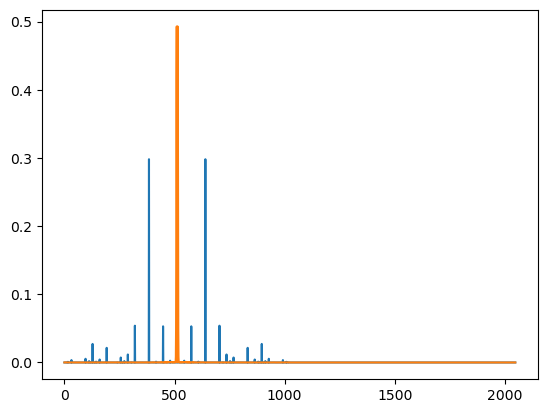

In [28]:
plt.plot(abs(np.diag(rho)))
plt.plot(abs(state))

In [29]:
state.conjugate().T @ rho @ state

np.complex128(4.347014946334857e-07-6.147499550896467e-20j)